In [1]:
#!/usr/bin/env python
import torch
import various_data_functions
from torch import nn
from torch import optim
from torch import Tensor
from torch.nn import functional as F
from models import *
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
N=10**3

In [58]:
#Base functions adapted from the practicals
def train_model(model, train_input, train_target,train_classes, mini_batch_size, test_input=None, test_target=None, crit=nn.CrossEntropyLoss, eta = 1e-3, nb_epochs = 50,print_=False, store_loss = False, aux_factor=1, store_error=False, checkpoint_name=None):
    #Initializing the loss, the optimizer, and the stored loss and errors for the plots
    criterion = crit()
    optimizer = optim.Adam(model.parameters(), lr=eta)
    stored_loss = []
    stored_error = []
    
    #Retrieving data if a similar model has already been trained or partially trained
    nb_epochs_finished = 0
    if checkpoint_name!=None:
        try:
            checkpoint = torch.load(checkpoint_name)
            nb_epochs_finished = checkpoint['nb_epochs_finished']
            model.load_state_dict(checkpoint['model_state'])
            optimizer.load_state_dict(checkpoint['optimizer_state'])
            if print_:
                print(f'Checkpoint loaded with {nb_epochs_finished} epochs finished.')
            stored_loss=checkpoint['stored_loss']
            if len(stored_loss)>nb_epochs*3:
                stored_loss=stored_loss[0:nb_epochs*3]
            stored_error=checkpoint['stored_error']
            if len(stored_error)>nb_epochs:
                stored_error=stored_error[0:nb_epochs]
        except FileNotFoundError:
            if print_:
                print('Starting from scratch.')
        except:
            print('Error when loading the checkpoint.')
            exit(1)
    
    #Training the network if the checkpoint wasn't fully trained
    for e in range(nb_epochs_finished,nb_epochs):
        
        #Initializing accumulated losses
        #loss1 is the loss over the output (identifying which number is greater)
        #loss2 and loss3 are the auxiliary losses trying to identify the numbers in the 2 input pictures
        acc_loss = 0
        acc_loss1 = 0
        acc_loss2 = 0
        acc_loss3 = 0
        
        #permuting the samples
        permuted_index = torch.randperm(train_input.size()[0])
        train_input_shuffled = train_input[permuted_index]
        train_target_shuffled = train_target[permuted_index]
        train_classes_shuffled = train_classes[permuted_index]
        
        
        for b in range(0, train_input.size(0), mini_batch_size):
            
            #forward pass
            output,aux_output = model(train_input_shuffled.narrow(0, b, mini_batch_size))
            if crit==nn.MSELoss:
                
                #computing the different losses
                loss1 = criterion(output[:,1], train_target_shuffled.narrow(0, b, mini_batch_size))
                loss2 = criterion(torch.argmax(aux_output[:,0:9],dim=1), train_classes_shuffled[:,0].narrow(0, b, mini_batch_size))
                loss3 = criterion(torch.argmax(aux_output[:,10:19],dim=1), train_classes_shuffled[:,1].narrow(0, b, mini_batch_size))
                loss = loss1 + loss2 + loss3
                print('|| loss1 req grad =', loss1.requires_grad, '|| loss2 req grad =',loss2.requires_grad,'|| loss3 req grad =', loss3.requires_grad)
            elif crit==nn.CrossEntropyLoss:
                loss1 = criterion(output, train_target_shuffled.narrow(0, b, mini_batch_size))
                loss2 = criterion(aux_output[:,0,:], train_classes_shuffled[:,0].narrow(0, b, mini_batch_size))
                loss3 = criterion(aux_output[:,1,:], train_classes_shuffled[:,1].narrow(0, b, mini_batch_size))
                loss = loss1 + aux_factor*(loss2 + loss3)
            else:
                print("Loss not implemented")
                
            #Update the accumulated losses
            acc_loss = acc_loss + loss.item()
            acc_loss1 = acc_loss1 + loss1.item()
            acc_loss2 = acc_loss2 + loss2.item()
            acc_loss3 = acc_loss3 + loss3.item()
            
            #zero the gradients
            model.zero_grad()
            
            #backward pass
            loss.backward()
            
            #optimizer step
            optimizer.step()
            
        #update the stored losses and error if needed
        if store_loss:
            stored_loss += [[acc_loss1], [acc_loss2], [acc_loss3]]
        if store_error:
            stored_error +=[compute_nb_errors(model, test_input, test_target, mini_batch_size)]
            
        #print the different losses if needed
        if print_:
            print(e, 'tot loss', acc_loss, 'loss1', acc_loss1, 'loss2', acc_loss2, 'loss3', acc_loss3)
            
        #save the checkpoint for later if needed
        if checkpoint_name!=None:
                checkpoint = {'nb_epochs_finished': e + 1,'model_state': model.state_dict(),'optimizer_state': optimizer.state_dict(),'stored_loss':stored_loss,'stored_error':stored_error}
                torch.save(checkpoint, checkpoint_name)
        
    #return the stored quantities  
    return torch.tensor(stored_loss),torch.tensor(stored_error)

#error computing function
def compute_nb_errors(model, input, target, mini_batch_size=100):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output , aux_output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[b + k]!=predicted_classes[k]:
                nb_errors = nb_errors + 1

    return nb_errors

#this function lets us do multiple runs more easily
def run_many_times(model,crit=nn.CrossEntropyLoss,mini_batch_size=100,n=10,print_=True,eta=1e-3,nb_epochs=25,aux_factor=0,shuffle=True, store_error=False,checkpoint_name=None):
    average_error=0
    losses=torch.empty(0,nb_epochs,3)
    errors=torch.empty(0,nb_epochs)
    for i in range(n):
        m=model()
        train_input,train_target,train_classes,test_input,test_target,test_classes=various_data_functions.data(N,True,False,nn.CrossEntropyLoss,shuffle=shuffle)
        if checkpoint_name!=None:
            checkpoint_name_spec=checkpoint_name+'try_'+str(i)+'.pth'
        else:
            checkpoint_name_spec=None
        new_losses,new_errors=train_model(m, train_input, train_target,train_classes,mini_batch_size,test_input=test_input, test_target=test_target,crit=crit,eta=eta,nb_epochs=nb_epochs,aux_factor=aux_factor,store_loss=True,store_error=store_error,checkpoint_name=checkpoint_name_spec)
        new_losses=new_losses.view(1,nb_epochs, 3)
        if store_error:
            new_errors= new_errors.view(1,nb_epochs)
            errors = torch.cat((errors,new_errors),0)
        if print_:
            losses = torch.cat((losses, new_losses), 0)
            nb_test_errors = compute_nb_errors(m, test_input, test_target, mini_batch_size)
            print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))
            average_error+=(100 * nb_test_errors) / test_input.size(0)
    if print_:
        print("Average error: "+str(average_error/n))
        avg_losses=torch.sum(losses,0)/n
        mod=int(torch.floor(torch.Tensor([nb_epochs/20])))
        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
        x_lab=torch.arange(nb_epochs)
        x_labels=x_lab[x_lab%mod==0].detach().numpy()
        ax0.errorbar(x_labels, avg_losses[x_lab%mod==0,0].detach().numpy(), yerr=torch.std(losses[:,:,0],0)[x_lab%mod==0].detach().numpy(), fmt='-o')
        ax0.set_title('evolution of the cross entropy loss')
        ax1.errorbar(x_labels, avg_losses[x_lab%mod==0,1].detach().numpy(), yerr=torch.std(losses[:,:,1],0)[x_lab%mod==0].detach().numpy(), fmt='o')
        ax1.errorbar(x_labels, avg_losses[x_lab%mod==0,2].detach().numpy(), yerr=torch.std(losses[:,:,2],0)[x_lab%mod==0].detach().numpy(), fmt='o')
        ax1.set_title('evolution of the auxiliary losses')
        plt.show()
    if store_error:
        return errors

#this function returns the number of parameters of a model
def n_params(model):
    n = 0
    for params in model.parameters():
        n += params.numel()
    return n

#this function uses the previous ones to build a big plot with several models
def big_error_plot(models,model_names,n=50,nb_epochs=100,eta=1e-3,div=25,name="big_error_plot.png",aux_factor=1):
    x_lab=torch.arange(nb_epochs)
    mod=int(torch.floor(torch.Tensor([nb_epochs/div])))
    x_labels=x_lab[x_lab%mod==0].detach().numpy()
    for i in range(len(models)):
        print("Starting model " + model_names[i])
        errors=run_many_times(models[i],crit=nn.CrossEntropyLoss,mini_batch_size=10,n=n,print_=False,eta=eta,nb_epochs=nb_epochs,aux_factor=aux_factor,shuffle=True, store_error=True,checkpoint_name='checkpoints/'+model_names[i]+'_'+str(aux_factor).replace('.','')+'_')
        #sns.relplot(x="timepoint", y="signal", col="region",hue="event", style="event", kind="line",)
        #plt.errorbar(x_labels,(errors.mean(dim=0)[x_lab%mod==0]/10).detach().numpy(),yerr=(torch.std(errors,dim=0)[x_lab%mod==0]/10).detach().numpy(),fmt='o')
        mean=(errors.mean(dim=0)[x_lab%mod==0]/10).detach().numpy()
        std=(torch.std(errors,dim=0)[x_lab%mod==0]/10).detach().numpy()
        plt.plot(x_labels,mean)
        plt.fill_between(x_labels,mean-std,mean+std,alpha=0.3)
        print('Mean number of errors after '+str(nb_epochs)+' epochs of training: '+str(errors.mean(dim=0)[-1])+' out of 1000 test samples with a standard deviation of '+str(torch.std(errors,dim=0)[-1]))
    plt.ylabel('Accuracy[%]')
    plt.xlabel('Number of epochs')
    plt.legend(model_names)
    plt.savefig(name,bbox_inches='tight')
    plt.show()

In [3]:
#inpuit images are 14*14 
shuffle = True
train_input,train_target,train_classes,test_input,test_target,test_classes=various_data_functions.data(N,True,False,nn.CrossEntropyLoss,shuffle=shuffle)

In [4]:
after = (14-3+1)/3
int(after), int(2*after**2*104)

(4, 3328)

In [5]:
class C1L2WS(nn.Module):
    def __init__(self):
        super().__init__()
        
        #convolutions. To be run in parallel on the 2 images 
        self.conv1 = nn.Conv2d(1, 104, kernel_size=3)
        
        #linear layer for the auxiliary losses. To be run in parallel on the 2 images 
        self.aux_linear = nn.Linear(4**2*104, 10)
        
        #The outputs of the convolutions will be merged in a single vector
        #Then, the following linear layers for the real loss will be used.
        self.fc1 = nn.Linear(2*4**2*104, 20)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        
        #crop the images in 2
        picture1 =x.narrow(1, 0, 1)
        picture2 =x.narrow(1, 1, 1)
        
        #computing the convolutions+relu in parallel on the two pictures.
        x1 = F.relu(F.max_pool2d(self.conv1(picture1), kernel_size=3, stride=3))
        x2 = F.relu(F.max_pool2d(self.conv1(picture2), kernel_size=3, stride=3))
        
        #Reshaping to make 2 vectors
        x1 = x1.view(-1, 4**2*104)
        x2 = x2.view(-1, 4**2*104)
        
        #computing the linear+softmax to make the auxiliary output
        a1 = F.softmax(self.aux_linear(x1), dim = 1).unsqueeze(1)
        a2 = F.softmax(self.aux_linear(x2), dim = 1).unsqueeze(1)
        #merging the vector to return the final auxiliary output
        aux_output = torch.cat((a1, a2), 1)
        
        #computing the linear layers for the final output
        x = torch.cat((x1,x2), 1)
        
        x = F.relu(self.fc1(x))
        output = F.softmax(self.fc2(x), dim=1)
        return output, aux_output

In [39]:
#checks
model = C1L2WS()
x = train_input[0:5]
output, aux_output = model(x)
print(aux_output)
output.shape, aux_output.shape
aux_output[4,1].sum()

tensor([[[0.0698, 0.0731, 0.1361, 0.0938, 0.0797, 0.1770, 0.1022, 0.0635,
          0.1380, 0.0667],
         [0.0844, 0.0536, 0.1123, 0.1097, 0.0854, 0.1795, 0.0989, 0.0756,
          0.1353, 0.0655]],

        [[0.0677, 0.0425, 0.0889, 0.0932, 0.0734, 0.2114, 0.1310, 0.0528,
          0.1775, 0.0617],
         [0.0825, 0.0699, 0.1638, 0.0956, 0.0639, 0.2206, 0.0880, 0.0504,
          0.0697, 0.0954]],

        [[0.0932, 0.0573, 0.1230, 0.1190, 0.0661, 0.1911, 0.0926, 0.0730,
          0.0925, 0.0922],
         [0.0885, 0.0453, 0.1253, 0.1192, 0.0364, 0.2807, 0.1315, 0.0359,
          0.0754, 0.0618]],

        [[0.0797, 0.0473, 0.1750, 0.1024, 0.0406, 0.2283, 0.1168, 0.0572,
          0.0719, 0.0808],
         [0.0937, 0.0557, 0.1163, 0.1096, 0.0815, 0.1789, 0.0925, 0.0561,
          0.1359, 0.0798]],

        [[0.0771, 0.0420, 0.1707, 0.1327, 0.0571, 0.2132, 0.0994, 0.0508,
          0.0943, 0.0626],
         [0.0569, 0.0431, 0.1285, 0.1271, 0.0660, 0.2283, 0.1159, 0.0498,
         

tensor(1., grad_fn=<SumBackward0>)

In [7]:
################################################################################################################
#check the sizes
after = (14-3+1)/3
int(after), int(2*after**2*16)

(4, 512)

In [8]:
class C1L3WS(nn.Module):
    def __init__(self):
        super().__init__()
        
        #convolutions. To be run in parallel on the 2 images
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        
        #linear layer for the auxiliary losses. To be run in parallel on the 2 images
        self.aux_linear = nn.Linear(4**2*16, 10)
        
        #The outputs of the convolutions will be merged in a single vector
        #Then, the following linear layers for the real loss will be used.
        self.fc1 = nn.Linear(2*4**2*16, 128)
        self.fc2 = nn.Linear(128, 20)
        self.fc3 = nn.Linear(20, 2)
        

    def forward(self, x):
        
        #crop the images in 2
        picture1 =x.narrow(1, 0, 1)
        picture2 =x.narrow(1, 1, 1)
        
        #computing the convolutions+relu in parallel on the two pictures.
        x1 = F.relu(F.max_pool2d(self.conv1(picture1), kernel_size=3, stride=3))
        x2 = F.relu(F.max_pool2d(self.conv1(picture2), kernel_size=3, stride=3))
        
        #Reshaping to make 2 vectors
        x1 = x1.view(-1, 4**2*16)
        x2 = x2.view(-1, 4**2*16)
        
        #computing the linear+softmax to make the auxiliary output
        a1 = F.softmax(self.aux_linear(x1), dim = 1).unsqueeze(1)
        a2 = F.softmax(self.aux_linear(x2), dim = 1).unsqueeze(1)
        #merging the vector to return the final auxiliary output
        aux_output = torch.cat((a1, a2), 1)
        
        #computing the linear layers for the final output
        x = torch.cat((x1,x2), 1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = F.softmax(self.fc3(x),dim=1)
        return output, aux_output

In [9]:
#checks
model = C1L3WS()
x = train_input[0:5]
output, aux_output = model(x)
output.shape, aux_output.shape

(torch.Size([5, 2]), torch.Size([5, 2, 10]))

In [10]:
################################################################################################################
#check the sizes
after = (14-3+1)/3
int(after), int(2*after**2*10)

(4, 320)

In [11]:
class C1L5WS(nn.Module):
    def __init__(self):
        super().__init__()
        
        #convolutions. To be run in parallel on the 2 images
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        
        #linear layer for the auxiliary losses. To be run in parallel on the 2 images 
        self.aux_linear = nn.Linear(4**2*10, 20)
        
        #The outputs of the convolutions will be merged in a single vector
        #Then, the following linear layers for the real loss will be used.
        self.fc1 = nn.Linear(2*4**2*10, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80,40)
        self.fc4 = nn.Linear(40,20)
        self.fc5 = nn.Linear(20, 2)
        self.aux_linear = nn.Linear(20, 20)

    def forward(self, x):
        
        
        #crop the images in 2
        picture1 =x.narrow(1, 0, 1)
        picture2 =x.narrow(1, 1, 1)
        
        #computing the convolutions+relu in parallel on the two pictures.
        x1 = F.relu(F.max_pool2d(self.conv1(picture1), kernel_size=3, stride=3))
        x2 = F.relu(F.max_pool2d(self.conv1(picture2), kernel_size=3, stride=3))
        
        #Reshaping to make 2 vectors
        x1 = x1.view(-1, 4**2*10)
        x2 = x2.view(-1, 4**2*10)
        
        #computing the linear+softmax to make the auxiliary output
        a1 = F.softmax(self.aux_linear(x1), dim = 1).unsqueeze(1)
        a2 = F.softmax(self.aux_linear(x2), dim = 1).unsqueeze(1)
        #merging the vector to return the final auxiliary output
        aux_output = torch.cat((a1, a2), 1)
        
        #computing the linear layers for the final output
        x = torch.cat((x1,x2), 1)
        
        x = F.relu(self.fc1(x.view(-1, 4**2*10)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        output = F.softmax(self.fc5(x),dim=1)
        return output, aux_output

In [12]:
#checks
model = C1L3WS()
x = train_input[0:5]
output, aux_output = model(x)
output.shape, aux_output.shape

(torch.Size([5, 2]), torch.Size([5, 2, 10]))

In [13]:
################################################################################################################
#check the sizes
after = 4
int(after), int(2*2**2*120)

(4, 960)

In [14]:
class C2L2WS(nn.Module):
    def __init__(self):
        super().__init__()
        
        #convolutions. To be run in parallel on the 2 images 
        self.conv1 = nn.Conv2d(1, 24, kernel_size=3)
        self.conv2 = nn.Conv2d(24, 120, kernel_size=3)
        
        #linear layer for the auxiliary losses. To be run in parallel on the 2 images 
        self.aux_linear = nn.Linear(2**2*120, 10)
        
        #The outputs of the convolutions will be merged in a single vector
        #Then, the following linear layers for the real loss will be used.
        self.fc1 = nn.Linear(2*2**2*120, 20)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        
        #crop the images in 2
        picture1 =x.narrow(1, 0, 1)
        picture2 =x.narrow(1, 1, 1)
        
        #computing the convolutions+relu in parallel on the two pictures.
        #first convolution
        x1 = F.relu(F.max_pool2d(self.conv1(picture1), kernel_size=2, stride=2))
        x2 = F.relu(F.max_pool2d(self.conv1(picture2), kernel_size=2, stride=2))
        #second convolution
        x1 = F.relu(F.max_pool2d(self.conv2(x1), kernel_size=2, stride=2))
        x2 = F.relu(F.max_pool2d(self.conv2(x2), kernel_size=2, stride=2))

        #Reshaping to make 2 vectors
        x1 = x1.view(-1, 2**2*120)
        x2 = x2.view(-1, 2**2*120)
        
        #computing the linear+softmax to make the auxiliary output
        a1 = F.softmax(self.aux_linear(x1), dim = 1).unsqueeze(1)
        a2 = F.softmax(self.aux_linear(x2), dim = 1).unsqueeze(1)
        #merging the vector to return the final auxiliary output
        aux_output = torch.cat((a1, a2), 1)
        
        #computing the linear layers for the final output
        x = torch.cat((x1,x2), 1)

        x = F.relu(self.fc1(x.view(-1, 2*2**2*120)))
        output = F.softmax(self.fc2(x), dim=1)
        return output, aux_output

In [15]:
#checks
model = C2L2WS()
x = train_input[0:5]
output, aux_output = model(x)
output.shape, aux_output.shape

(torch.Size([5, 2]), torch.Size([5, 2, 10]))

In [16]:
################################################################################################################
#check the sizes
after = 4
int(after), int(2*2**2*64)

(4, 512)

In [17]:
class C2L3WS(nn.Module):
    def __init__(self):
        super().__init__()
        
        #convolutions. To be run in parallel on the 2 images 
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3)
        
        #linear layer for the auxiliary losses. To be run in parallel on the 2 images 
        self.aux_linear = nn.Linear(2**2*64, 10)
        
        #The outputs of the convolutions will be merged in a single vector
        #Then, the following linear layers for the real loss will be used.
        self.fc1 = nn.Linear(2*2**2*64, 60)
        self.fc2 = nn.Linear(60, 20)
        self.fc3 = nn.Linear(20, 2)

    def forward(self, x):
        
        #crop the images in 2
        picture1 =x.narrow(1, 0, 1)
        picture2 =x.narrow(1, 1, 1)
        
        #computing the convolutions+relu in parallel on the two pictures.
        #first convolution
        x1 = F.relu(F.max_pool2d(self.conv1(picture1), kernel_size=2, stride=2))
        x2 = F.relu(F.max_pool2d(self.conv1(picture2), kernel_size=2, stride=2))
        #second convolution
        x1 = F.relu(F.max_pool2d(self.conv2(x1), kernel_size=2, stride=2))
        x2 = F.relu(F.max_pool2d(self.conv2(x2), kernel_size=2, stride=2))
        
        #Reshaping to make 2 vectors
        x1 = x1.view(-1, 2**2*64)
        x2 = x2.view(-1, 2**2*64)
        
        #computing the linear+softmax to make the auxiliary output
        a1 = F.softmax(self.aux_linear(x1), dim = 1).unsqueeze(1)
        a2 = F.softmax(self.aux_linear(x2), dim = 1).unsqueeze(1)
        #merging the vector to return the final auxiliary output
        aux_output = torch.cat((a1, a2), 1)
        
        #computing the linear layers for the final output
        x = torch.cat((x1,x2), 1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = F.softmax(self.fc3(x), dim=1)
        return output, aux_output

In [18]:
#checks
model = C2L3WS()
x = train_input[0:5]
output, aux_output = model(x)
output.shape, aux_output.shape

(torch.Size([5, 2]), torch.Size([5, 2, 10]))

In [19]:
################################################################################################################
#check the sizes
after = 4
int(after), int(2*4**2*44)

(4, 1408)

In [20]:
class C3L2WS(nn.Module):
    def __init__(self):
        super().__init__()
        
        #convolutions. To be run in parallel on the 2 images
        self.conv1 = nn.Conv2d(1, 11, kernel_size=3)
        self.conv2 = nn.Conv2d(11, 22, kernel_size=3)
        self.conv3 = nn.Conv2d(22, 44, kernel_size=3)
        
        #linear layer for the auxiliary losses. To be run in parallel on the 2 images 
        self.aux_linear = nn.Linear(4**2*44, 10)
        
        #The outputs of the convolutions will be merged in a single vector
        #Then, the following linear layers for the real loss will be used.
        self.fc1 = nn.Linear(2*4**2*44, 20)
        self.fc2 = nn.Linear(20, 2)

        
    def forward(self, x):
        #crop the images in 2
        picture1 =x.narrow(1, 0, 1)
        picture2 =x.narrow(1, 1, 1)
        
        #computing the convolutions+relu in parallel on the two pictures.
        #first convolution
        x1 = F.relu(self.conv1(picture1))
        x2 = F.relu(self.conv1(picture2))
        #second convolution
        x1 = F.relu(self.conv2(x1))
        x2 = F.relu(self.conv2(x2))
        #third convolution
        x1 = F.relu(F.max_pool2d(self.conv3(x1), kernel_size=2, stride=2))
        x2 = F.relu(F.max_pool2d(self.conv3(x2), kernel_size=2, stride=2))
        
        
        #Reshaping to make 2 vectors
        x1 = x1.view(-1, 4**2*44)
        x2 = x2.view(-1, 4**2*44)
        
        #computing the linear+softmax to make the auxiliary output
        a1 = F.softmax(self.aux_linear(x1), dim = 1).unsqueeze(1)
        a2 = F.softmax(self.aux_linear(x2), dim = 1).unsqueeze(1)
        #merging the vector to return the final auxiliary output
        aux_output = torch.cat((a1, a2), 1)
        
        #computing the linear layers for the final output
        x = torch.cat((x1,x2), 1)
        
        x = F.relu(self.fc1(x))
        output = F.softmax(self.fc2(x), dim=1)
        return output, aux_output

In [21]:
#checks
model = C3L2WS()
x = train_input[0:5]
output, aux_output = model(x)
output.shape, aux_output.shape

(torch.Size([5, 2]), torch.Size([5, 2, 10]))

In [65]:
#########################################################################################################################
##########################################################################################################################
#NOW done for those below 

In [66]:
class C4L2WS_bis(nn.Module):#bis got changed
    def __init__(self):
        super().__init__()
        
        #convolutions. To be run in parallel on the 2 images
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=3)
        self.conv3 = nn.Conv2d(12, 24, kernel_size=3)
        self.conv4 = nn.Conv2d(24, 48, kernel_size=3)
        
        #linear layer for the auxiliary losses. To be run in parallel on the 2 images 
        self.aux_linear = nn.Linear(3**2*48, 10)
        
        #The outputs of the convolutions will be merged in a single vector
        #Then, the following linear layers for the real loss will be used.
        self.fc1 = nn.Linear(864, 20)
        self.fc2 = nn.Linear(20, 2)

        
    def forward(self, x):
        #crop the images in 2
        picture1 =x.narrow(1, 0, 1)
        picture2 =x.narrow(1, 1, 1)
        
        #computing the convolutions+relu in parallel on the two pictures.
        #first convolution        
        x1 = F.relu(self.conv1(picture1))
        x2 = F.relu(self.conv1(picture2))
        #second convolution
        x1 = F.relu(self.conv2(x1))
        x2 = F.relu(self.conv2(x2))
        #third convolution
        x1 = F.relu(self.conv3(x1))
        x2 = F.relu(self.conv3(x2))
        #fourth convolution
        x1 = F.relu(F.max_pool2d(self.conv4(x1), kernel_size=2, stride=2))
        x2 = F.relu(F.max_pool2d(self.conv4(x2), kernel_size=2, stride=2))
        
        #Reshaping to make 2 vectors
        x1 = x1.view(-1, 3**2*48)
        x2 = x2.view(-1, 3**2*48)
        
        #computing the linear+softmax to make the auxiliary output
        a1 = F.softmax(self.aux_linear(x1), dim = 1).unsqueeze(1)
        a2 = F.softmax(self.aux_linear(x2), dim = 1).unsqueeze(1)
        #merging the vector to return the final auxiliary output
        aux_output = torch.cat((a1, a2), 1)
        
        #computing the linear layers for the final output
        x = torch.cat((x1,x2), 1)

        x = F.relu(self.fc1(x))
        output = F.softmax(self.fc2(x), dim=1)
        return output, aux_output

In [67]:
class C4L2WS(nn.Module):
    def __init__(self):
        super().__init__()
        
        #convolutions. To be run in parallel on the 2 images
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=2)
        
        #linear layer for the auxiliary losses. To be run in parallel on the 2 images 
        self.aux_linear = nn.Linear(3**2*64, 10)
        
        #The outputs of the convolutions will be merged in a single vector
        #Then, the following linear layers for the real loss will be used.
        self.fc1 = nn.Linear(1152, 20)
        self.fc2 = nn.Linear(20, 2)

        
    def forward(self, x):
        #crop the images in 2
        picture1 =x.narrow(1, 0, 1)
        picture2 =x.narrow(1, 1, 1)
        
        #computing the convolutions+relu in parallel on the two pictures.
        #first convolution        
        x1 = F.relu(self.conv1(picture1))
        x2 = F.relu(self.conv1(picture2))
        #second convolution
        x1 = F.relu(F.max_pool2d(self.conv2(x1), kernel_size=2, stride=2))
        x2 = F.relu(F.max_pool2d(self.conv2(x2), kernel_size=2, stride=2))
        #third convolution
        x1 = F.relu(self.conv3(x1))
        x2 = F.relu(self.conv3(x2))
        #fourth convolution
        x1 = F.relu(self.conv4(x1))
        x2 = F.relu(self.conv4(x2))
        
        #Reshaping to make 2 vectors
        x1 = x1.view(-1, 3**2*64)
        x2 = x2.view(-1, 3**2*64)
        
        #computing the linear+softmax to make the auxiliary output
        a1 = F.softmax(self.aux_linear(x1), dim = 1).unsqueeze(1)
        a2 = F.softmax(self.aux_linear(x2), dim = 1).unsqueeze(1)
        #merging the vector to return the final auxiliary output
        aux_output = torch.cat((a1, a2), 1)
        
        #computing the linear layers for the final output
        x = torch.cat((x1,x2), 1)

        x = F.relu(self.fc1(x))
        output = F.softmax(self.fc2(x), dim=1)
        return output, aux_output

In [26]:
m=C1L2WS()
print(n_params(m))

84312


In [28]:
m=C1L3WS()
print(n_params(m))

71016


In [30]:
m=C1L5WS()
print(n_params(m))

68862


In [31]:
m=C2L2WS()
print(n_params(m))

50352


In [32]:
m=C2L3WS()
print(n_params(m))

44052


In [33]:
m=C3L2WS()
print(n_params(m))

46338


In [34]:
m=C4L2WS_bis()
print(n_params(m))

31094


In [35]:
m=C4L2WS()
print(n_params(m))

34686


test error Net 15.70% 157/1000
test error Net 16.60% 166/1000
test error Net 15.40% 154/1000
Average error: 15.899999999999999


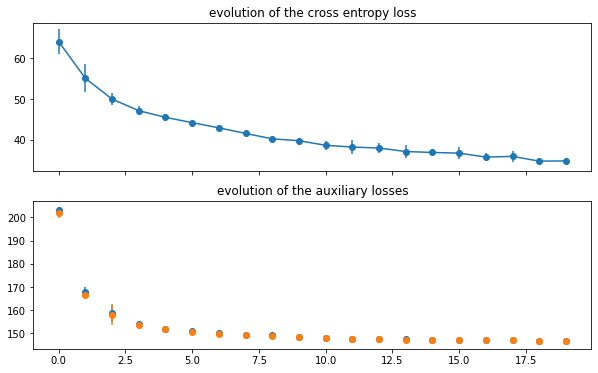

In [61]:
model=C2L2WS
run_many_times(model,crit=nn.CrossEntropyLoss,mini_batch_size=10,n=3,print_=True,eta=1e-3,nb_epochs=20,aux_factor=1,shuffle=True, store_error=False,checkpoint_name=None)

In [ ]:
#To test the function
models=[Net3328Aux20WS,Net512_128Aux20WS]
model_names=['Net3328Aux20WS','Net512_128Aux20WS']
big_error_plot(models,model_names,n=3,nb_epochs=10,div=10,name="TestPlot.png")

In [ ]:
models=[C1L2WS,C2L2WS,C2L3WS,C3L2WS,C4L2WS]
model_names=['C1L2WS','C2L2WS','C2L3WS','C3L2WS','C4L2WS']
big_error_plot(models,model_names,n=20,nb_epochs=20,name='big_plot_WS_aux=1.png',div=20)

Starting model C1L2WS


In [ ]:
#Same as before with aux_factor=0.1
models=[C1L2WS,C2L2WS,C2L3WS,C3L2WS,C4L2WS]
model_names=['C1L2WS','C2L2WS','C2L3WS','C3L2WS','C4L2WS']
big_error_plot(models,model_names,n=10,nb_epochs=20,aux_factor=0.1,name='big_plot_WS_aux=01.png',div=20)

In [ ]:
#Same as before with aux_factor=1
models=[C1L2WS,C2L2WS,C2L3WS,C3L2WS,C4L2WS]
model_names=['C1L2WS','C2L2WS','C2L3WS','C3L2WS','C4L2WS']
big_error_plot(models,model_names,n=10,nb_epochs=20,aux_factor=1,name='big_plot_WS_aux=0.png',div=20)